In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import networkx as nx
import numpy as np
from contextily import add_basemap
from libpysal import weights
import time
import shapely
import heapq

# BlazeNav
Comparing Bellman-Ford and Dijkstra's Algorithms to find the shortest path between the Gainesville Fire Station and a user-inputted fire location.

In [25]:
# Read road network data in Alachua County (181,572 rows)
roads = gpd.read_file('road_vertices_3857.zip')[['LengthM', 'geometry', 'FULLNAME', 'MTFCC', 'StartX', 'StartY']]
# Subset to primary and secondary roads (19,398)
roads = roads[(roads['MTFCC'] == 'S1100') | (roads['MTFCC'] == 'S1200')]

# Create graph (based on Networkx documentation)
G = momepy.gdf_to_nx(roads, approach="primal", length="LengthM")
nx.set_node_attributes(G, np.inf, "dist")
nx.set_node_attributes(G, None, "pred")

Text(0.5, 1.0, 'Primary and Secondary Roads in Alachua County')

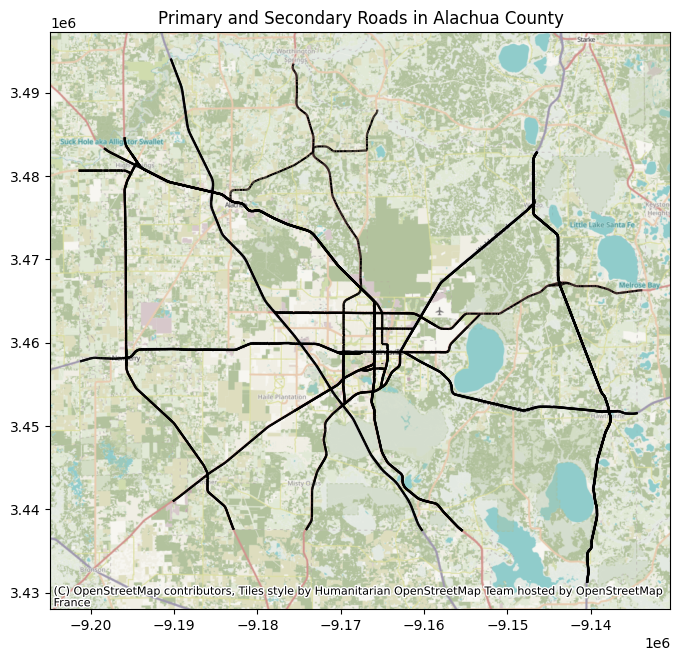

In [27]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))
roads.plot(color='k', ax=ax)
add_basemap(ax=ax)
ax.set_aspect('equal')
ax.set_title("Primary and Secondary Roads in Alachua County")

In [4]:
def bellmanford(Graph):
    # Gainesville Fire Station
    Graph.nodes[(-9164362.209753478, 3458275.7772084177)]['dist'] = 0
    for i in range(len(list(G.nodes)) - 1):
      for from_vertex in Graph.nodes:
          neighbors = Graph.__getitem__(from_vertex)
          for to_vertex in neighbors:
              du = Graph.nodes[from_vertex]['dist']
              wt = neighbors[to_vertex][0]['LengthM']
              dv = Graph.nodes[to_vertex]['dist']
              if du + wt < dv:
                  Graph.nodes[to_vertex]['dist'] = du + wt
                  Graph.nodes[to_vertex]['pred'] = from_vertex
    return Graph

# Based off of pseudocode from discussion slides
# repeat V - 1 times
# for each edge(from u, to v) with weight w in edges do:
#     if dist[u] + w < dist[v] then
#         dist[v] = dist[u] + w
#         pred[v] = u

In [5]:
def dijkstra(Graph):
    # Initialize everything
    # Start is the index of Gainesville's Fire Station
    Graph.nodes[(-9164362.209753478, 3458275.7772084177)]['dist'] = 0
    # Initialize priority queue
    pq = [(0, (-9164362.209753478, 3458275.7772084177))]
    visitedNodes = set()

    while pq:
        current_distance, current = heapq.heappop(pq)
        if current in visitedNodes:
            continue
        visitedNodes.add(current)
        currentNeighbors = Graph.__getitem__(current)
        for neighboringNodes in currentNeighbors:
            weight = currentNeighbors[neighboringNodes][0]['LengthM']
            distance = current_distance + weight

            # If distance is less than the current distance, update
            if distance < Graph.nodes[neighboringNodes]['dist']:
                Graph.nodes[neighboringNodes]['dist'] = distance
                Graph.nodes[neighboringNodes]['pred'] = current
                heapq.heappush(pq, (distance, neighboringNodes))
    return Graph

In [6]:
path = nx.MultiGraph()
def findpath(node, Graph):
    # Input node is for fire
    source = (-9164362.209753478, 3458275.7772084177) # Gainesville Fire Station
    if Graph.nodes[node]['pred'] == source:
        path.add_node(node, dist = Graph.nodes[node]['dist'], pred = Graph.nodes[node]['pred'])
    else:
        pred = Graph.nodes[node]['pred']
        path.add_node(pred, dist = Graph.nodes[pred]['dist'], pred = Graph.nodes[pred]['pred'])
        path.add_edge(pred, node, weight = Graph.nodes[pred]['dist'])
        findpath(pred, Graph)

In [28]:
# Example 1: lat = 29.6520652, lon = -82.3111426
# Example 2: lat = 29.6693185, lon = -82.3310386
print("Welcome to BlazeNav! We will help you determine the closest path from the Gainesville Fire Station to a fire you've just located.")
print("-------------------------------------------------------------")
print("Please enter the coordinates of your fire in decimal degrees.")
fire_lon = input("Enter longtiude of fire: ")
fire_lat = input("Enter latitude of fire: ")

# Find the closest street to the input coordinates and use that as the destination
try:
  # References https://stackoverflow.com/questions/70626218/how-to-find-the-nearest-linestring-to-a-point
  fire_point = gpd.GeoDataFrame(geometry=[shapely.wkt.loads(f"POINT ({fire_lon} {fire_lat})")]).set_crs('EPSG:4326').to_crs('EPSG:3857')
  distance = gpd.sjoin_nearest(fire_point, roads).merge(roads, left_on='index_right', right_index=True)
  distance['distance'] = distance.apply(lambda row: row['geometry_x'].distance(row['geometry_y']), axis=1)
  closest_node_X = distance.iloc[0]['StartX_y']
  closest_node_Y = distance.iloc[0]['StartY_y']
  print("Success! We have identified the fire's location.")
except:
  print("Coordinates not found in or near Alachua County. Please enter new coordinates.")
  fire_lat = input()
  fire_lon = input()

Welcome to BlazeNav! We will help you determine the closest path from the Gainesville Fire Station to a fire you've just located.
-------------------------------------------------------------
Please enter the coordinates of your fire in decimal degrees.
Enter longtiude of fire: -82.3310386
Enter latitude of fire: 29.6693185
Success! We have identified the fire's location.


In [29]:
print("-------------------------------------------------------------")
print("Please enter 1 or 2 to select which algorithm you wish to run: \n1. Bellman-Ford algorithm\n2. Dijkstra's algorithm")
option = input("Algorithm: ")
print("-------------------------------------------------------------")
print('Thank you. BlazeNav is now searching for the fastest route from the Gainesville Fire Station #1 to the road nearest to the fire you inputted.')

-------------------------------------------------------------
Please enter 1 or 2 to select which algorithm you wish to run: 
1. Bellman-Ford algorithm
2. Dijkstra's algorithm
Algorithm: 2
-------------------------------------------------------------
Thank you. BlazeNav is now searching for the fastest route from the Gainesville Fire Station #1 to the road nearest to the fire you inputted.


In [30]:
# Find the closest node of the inputted fire coordinates
for id, node in enumerate(list(G.nodes)):
  if (node[0] <= closest_node_X + 1) & (node[0] >= closest_node_X - 1): # Account for rounding issues
    break

if option == '1':
    start = time.time()
    result = bellmanford(G)
    end = time.time()
    print("The algorithm took ", (end-start), " seconds to run.")
    path = nx.MultiGraph()
    findpath(node, result)

if option == '2':
    start = time.time()
    result = dijkstra(G)
    end = time.time()
    print("The algorithm took ", (end-start), " seconds to run.")
    path = nx.MultiGraph()
    findpath(node, result)

The algorithm took  0.042612314224243164  seconds to run.


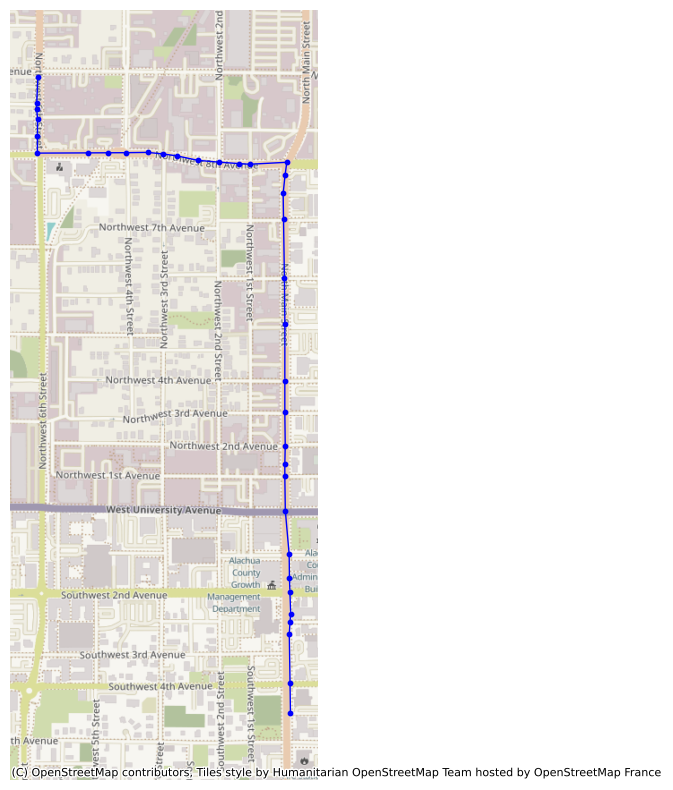

In [31]:
# Plot the path on a map
f, ax = plt.subplots(1, 1, figsize=(10, 10))
nx.draw(
    path, {n: [n[0], n[1]] for n in list(path.nodes)}, ax=ax, node_size=10, node_color='blue', edge_color='blue'
)
add_basemap(ax)
ax.set_aspect('equal')